# Multiple vessels of different types with random injection

In [39]:
# package(s) related to time, space and id
import datetime, time
import platform
import random
import os
import pathlib
import warnings

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import ast

# OpenTNSIM
import opentnsim
import opentnsim.core as core
import opentnsim.graph_module as graph_module
import opentnsim.plot as plot

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
from shapely.geometry import Point
print("This notebook is executed with OpenTNSim version {}".format(opentnsim.__version__))

This notebook is executed with OpenTNSim version 1.1.2


In [40]:
# Graph location
location_graph = 'C:/Users/npourmohammadz/OneDrive - Delft University of Technology/OpenTNSim/notebooks'

name_graph = 'C:/Users/npourmohammadz/OneDrive - Delft University of Technology/OpenTNSim/notebooks/Shape-Files/Amsterdam-Canals/final_network_v4.shp'


# Create the graph

In [41]:
# Create graph
graph = graph_module.Graph()
graph.from_shape(location_graph, name_graph)
graph.create_graph_new_projection()
# graph.plot()

In [42]:
# Edges to be removed

#prinsengracht
edges_to_remove_1 = [(352,351),(353,352),(296,353),(297,296),(280,297),(249,280),(250,249),(251,250),
                     (201,251),(202,201),(203,202),(142,203),(121,142),(122,121),(85,122),(88,85),
                     (31,88),(34,31),(35,34),(20,35),(36,20),(37,36),(38,37),(39,38)] 

#eenhoornssluis
edges_to_remove_2 = [(351,367),(367,368),(368,369),(369,366),(366,365)]

#grimburgerwal
edges_to_remove_3 = [(150,149)]

#singelgracht
edges_to_remove_4 = [(5,4),(4,6),(6,3),(3,2)]

#eenhoornsluis & haarlemmersluis
edges_to_remove_5 = [(351,354),(354,338)]

edges_to_remove = edges_to_remove_1+edges_to_remove_2+edges_to_remove_3+edges_to_remove_4+edges_to_remove_5

node_list = list(graph.graph.nodes())
coord_list = [eval(tuple_str) for tuple_str in node_list]
edges_as_coordinates = [(coord_list[i], coord_list[j]) for i, j in edges_to_remove]

FG = graph.graph.to_directed()
edges_as_strings = [(f'({x:.6f}, {y:.6f})', f'({u:.6f}, {v:.6f})') for (x, y), (u, v) in edges_as_coordinates]

# Remove the edges from the graph
FG.remove_edges_from(edges_as_strings)

In [43]:
# # for my internal purpose (Not a part of the code)

# given_point = '(4.898766, 52.367586)'
# points_list = list(FG.nodes())

# import ast
# import math

# # Function to convert string-form coordinates to tuples
# def convert_to_tuple(coord_str):
#     return ast.literal_eval(coord_str)

# # Function to calculate the Euclidean distance between two points
# def calculate_distance(point1, point2):
#     return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

# # Function to find the nearest point
# def find_nearest_point(target_point, point_list):
#     target_point = convert_to_tuple(target_point)
#     point_list = [convert_to_tuple(coord_str) for coord_str in point_list]

#     min_distance = float('inf')
#     nearest_point = None

#     for point in point_list:
#         distance = calculate_distance(target_point, point)
#         if distance < min_distance:
#             min_distance = distance
#             nearest_point = point

#     return nearest_point

# nearest_point = find_nearest_point(given_point, points_list)
# print(f"The nearest point to {given_point} is {nearest_point}")

In [44]:
# # for my internal purpose
# info_attribute = list(FG.edges(data=True))[0][2]['Info']

# # Get the keys (subheadings) of the Info attribute
# info_attribute_keys = list(info_attribute.keys())

# # Print the keys (subheadings) for the Info attribute of the first edge
# print("Keys for the Info attribute of the first edge:", info_attribute_keys)

In [45]:
# Turnaround edges
turnaround_edges = [(236,258),(258,236),(259,258),(303,285),(285,303),(285,236),(236,285)]
turnaround_edges_c = [(coord_list[i], coord_list[j]) for i, j in turnaround_edges]
turnaround_edges_strings = [(f'({x:.6f}, {y:.6f})', f'({u:.6f}, {v:.6f})') for (x, y), (u, v) in turnaround_edges_c]

for source_node, target_node in turnaround_edges_strings:
    # Find the edge with source_node and target_node
    edge_data = FG[source_node][target_node]
    
    # Update 'turnaround' to 1
    edge_data['Info']['turnaround'] = 1


In [46]:
# Crossings
crossing =[]
not_server_list =[285, 236, 259, 159, 322, 334, 355, 361, 364, 365, 372, 15, 26] # Not every intersection is a crossing
server_list_5 = [39, 52, 82, 2]
server_list_2 = [20, 351, 338, 331, 330]

coord_list2 = [eval(tuple_str) for tuple_str in node_list]

not_server_list_c = [coord_list2[i] for i in not_server_list] 
server_list_5_c = [coord_list2[i] for i in server_list_5] 
server_list_2_c = [coord_list2[i] for i in server_list_2]

for i in list(FG.nodes):
    neighbors = [n for n in FG[i]]
    if len(neighbors)>2 and i not in not_server_list_c :
        crossing.append(i)
        
crossing_c = [eval(tuple_str) for tuple_str in crossing]        
crossing_cs = [f'({x:.6f}, {y:.6f})' for (x , y) in crossing_c] 

server_list_5_cs = [f'({x:.6f}, {y:.6f})' for (x , y) in server_list_5_c] 
server_list_2_cs = [f'({x:.6f}, {y:.6f})' for (x , y) in server_list_2_c] 


crossing_resources = {}

for node in crossing_cs:
    if node in server_list_5_cs:
        crossing_resources[node] = 5  
    elif node in server_list_2_cs:
        crossing_resources[node] = 2  
    else:
        crossing_resources[node] = 3  
        
oneway_bridges = [296, 280, 249, 201, 142, 121, 85, 31, 20]
oneway_bridges_c = [coord_list[i] for i in oneway_bridges] 
oneway_bridges_cs = [f'({x:.6f}, {y:.6f})' for (x , y) in oneway_bridges_c] 

bridge_resources = {}

for node in oneway_bridges_cs:
    bridge_resources[node] = 1
    
merged_resources = {**crossing_resources, **bridge_resources} 

# Arrival patterns

In [47]:
# Traffic Scenario:
# 1: Weekend, Summer Traffic High    2: Weekday, Summer Traffic Medium
# 3: Weekday, Winter Traffic Low     4: Weekend, Winter Traffic Very Low

traffic_scenario = 3

if traffic_scenario == 1:
    mean_enter = {'FPPV': 1000, 'SPPV':1000, 'RPPV':1000, 'CFV':1000}
elif traffic_scenario == 2:
    mean_enter = {'FPPV': 1000, 'SPPV':1000, 'RPPV':1000, 'CFV':1000}    
elif traffic_scenario == 3:
    mean_enter = {'FPPV': 1000, 'SPPV':1000, 'RPPV':1000, 'CFV':1000}
else:
    mean_enter = {'FPPV': 1000, 'SPPV':1000, 'RPPV':1000, 'CFV':1000}

    
if traffic_scenario == 1:
    simulation_start = datetime.datetime(2023, 7, 17, 8, 0, 0, 0)
elif traffic_scenario == 2:
    simulation_start = datetime.datetime(2023, 7, 15, 8, 0, 0, 0)   
elif traffic_scenario == 3:
    simulation_start = datetime.datetime(2023, 1, 14, 8, 0, 0, 0)
else:
    simulation_start = datetime.datetime(2023, 1, 16, 8, 0, 0, 0)

# Vessels

In [48]:
# Make a class 
TransportResource = type('TransportResource', 
                         (core.Identifiable, core.Movable, 
                          core.HasResource, core.Routable,
                         core.ExtraMetadata), {})

# def compute_v_provider(v_empty, v_full):
#     return lambda x: 1

vessel_data = {
    'FPPV': {"env": None,
             "name": "Vessel",
             "route": None,
             "geometry": shapely.geometry.Point(0, 0),  # lon, lat
             "capacity": 1_000,
             "v": 6},
    'SPPV': {"env": None,
             "name": "Vessel",
             "route": None,
             "geometry": shapely.geometry.Point(0, 0),  # lon, lat
             "capacity": 2_000,
             "v": 5.5},
    'RPPV': {"env": None,
             "name": "Vessel",
             "route": None,
             "geometry": shapely.geometry.Point(0, 0),  # lon, lat
             "capacity": 3_000,
             "v": 5},
    'FCV': {"env": None,
             "name": "Vessel",
             "route": None,
             "geometry": shapely.geometry.Point(0, 0),  # lon, lat
             "capacity": 3_000,
             "v": 4.5}    
}


# Paths

In [49]:
# Tourist attractions and start points
# start_points = {
#     #stromma & andere hotspots voor chartervaart
#     'prinsengracht' : 121,
#     'rijksmuseum':63,
#     'annefrank': 280,
#     'damrak': 316,
#     'stationsplein': 319,
#     #salon schepen
#     'singelgracht 1': 290,
#     'singelgracht 2':291,
#     'oude turfmarkt':119,
#     'oude schans1 ': 204,
#     'waalseilandsgrahct': 286,
#     'prinsengracht onder': 35
# }

# attractions = {
#     'annefrank' : [296],
#     'magerebrug': [56],
#     'redlightdistrict' : [268],

#     'prinsengracht 1' : [250],
#     'prinsengracht 2' : [202],
#     'prinsengracht 5': [121],
#     'prinsengracht 4' : [35],
#     'prinsengracht 6' : [353],

#     'artis 1' : [114],
#     'artis 2' : [113],

#     'rijksmuseum' : [10],
#     'stnicolaasbassilica' : [302],
#     'scheepsvaartmuseum' : [192], 
#     'rembrandhuisenwaterlooplein' : [147],
#     'st antonie sluis': [193],
#     'st antonie sluis2': [194],

#     'keizersgracht boven 1':[337],
#     'keizersgracht boven 2':[336],

#     'keizersgracht midden & negenstraatjes 1':[238],
#     'keizersgracht midden & negenstraatjes 2':[230],

#     'keizersgracht beneden 1':[109],
#     'keizersgracht beneden 2':[107],

#     'heerengracht boven': [311],
#     'heerengracht midden 1':[248],
#     'heerengracht midden 2': [246],
#     'heerengracht beneden (goudenbocht) 1' : [126],
#     'heerengracht beneden (goudenbocht) 2' : [127],

#     'singel boven': [329],
#     'singel midden 1' :[293],
#     'singel midden 2': [290],


#     'singelgracht boven 1':[360],
#     'singelgracht boven 2':[358],
#     'singelgracht midden 1':[224],
#     'singelgracht midden 2':[101],
#     'singelgracht onder 1' :[6],
#     'singelgracht onder 2':[4],

#     'singelgracht onder 3': [111],
#     'oude centrum 1': [168],
#     'oude centrum 2': [167],
#     'oude centrum 3': [173],
#     'oude centrum 5': [207],
#     'oude schans': [204],
#     "prinshendrikkade ":[288],
#     'jordaan 1':[130],
#     'jordaan 3':[143],
#     'jordaan 4':[144],
#     'jordaan 5': [199],
#     'jordaan 6': [255],
#     'jordaan 7': [305],
#     'amstelsluizen': [28],
#     'noordelijk jordaan':[377]
# }

starting_points = [63, 316, 319, 290, 291, 119, 286]
attractions = [56, 268, 250, 202, 35, 353, 114, 113, 10, 302, 192, 147, 193, 194, 
               337, 336, 238, 230, 109, 107, 311, 248, 246, 126, 127, 329, 293, 360, 
               358, 224, 101, 6, 4, 111, 168, 167, 173, 207, 204, 288, 130, 143, 144,
               199, 255, 305, 28, 377]

# reference_distance_FPPV = 12
reference_distance_SPPV = 12

In [50]:
def quick_distance(coord1, coord2):
    R = 6371.0
    x1, y1 = coord1
    x2, y2 = coord2    
    lat1 = math.radians(y1)
    lon1 = math.radians(x1)
    lat2 = math.radians(y2)
    lon2 = math.radians(x2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance


In [51]:
# Fixed path passenger vessels (FPPV)
potential_routes = []
potential_routes_c = []
potential_routes_cs = []

for i in starting_points:
    starting_point = i
    sorted_nodes = [starting_point]
    
    total_distance = 0
    end_lag = 0
    remaining_nodes = random.sample(attractions, 35)
    while len(remaining_nodes) > 0:
        last_node = sorted_nodes[-1]   
        nearest_node = min(remaining_nodes, key=lambda x: (quick_distance(coord_list[last_node], coord_list[x])
                                                           + quick_distance(coord_list[starting_point], coord_list[x])))        
        sorted_nodes.append(nearest_node)
        remaining_nodes = [node for node in attractions if node not in sorted_nodes]

    route = sorted_nodes.copy()
    route.append(starting_point)
    route_c = [coord_list[node] for node in route]
    route_cs = [(f'({x:.6f}, {y:.6f})') for x, y in route_c]
    potential_routes.append(route)  
    potential_routes_c.append(route_c)
    potential_routes_cs.append(route_cs)
    
def FPPV_path(candidate_route):
    path = []
    for i in range(len(candidate_route) - 1):
        start_node, end_node = candidate_route[i], candidate_route[i + 1]
        shortest_path = nx.dijkstra_path(FG, start_node, end_node)
        if i == 0:
            path.extend(shortest_path)
        else: 
            path.extend(shortest_path[1:])
    return path

In [52]:
# Semi-random path passenger vessels (SPPV)
def SPPV_path(FG, starting_points, attractions):
    starting_point = random.choice(starting_points)
    route = [starting_point]
    path = []
    
    total_distance = 0
    end_lag = 0
    remaining_nodes = attractions.copy()
    
    while total_distance + end_lag < reference_distance_SPPV and len(remaining_nodes) > 0:
        last_node = route[-1]
        sorted_nodes = sorted(remaining_nodes, 
                               key=lambda x: (quick_distance(coord_list[last_node], coord_list[x])))
        n = min(len(sorted_nodes) , 2)
        nearest_nodes = sorted_nodes[:n]
        next_node = random.choice(nearest_nodes)
        route.append(next_node)
        remaining_nodes = [node for node in attractions if node not in route]
        total_distance = total_distance + quick_distance(coord_list[last_node], coord_list[next_node])
        end_lag = quick_distance(coord_list[next_node], coord_list[starting_point])
        
        shortest_path = nx.dijkstra_path(FG, (f'({coord_list[last_node][0]:.6f}, {coord_list[last_node][1]:.6f})'),
                                        (f'({coord_list[next_node][0]:.6f}, {coord_list[next_node][1]:.6f})'))
        if last_node == starting_point:
            path.extend(shortest_path)
        else: 
            path.extend(shortest_path[1:])

    return path  

In [53]:
# Random path passenger vessels (RPPV)
def RPPV_path(FG, bridge_s, cross_s):
    i_d = 0
    while i_d != 1:
        origin_i = random.choice(list(FG))
        destination_i = random.choice(list(FG))
        if (origin_i != destination_i 
            and origin_i not in bridge_s and origin_i not in cross_s 
            and destination_i not in bridge_s and destination_i not in cross_s):
            i_d = 1
            origin = origin_i
            destination = destination_i
    path = nx.dijkstra_path(FG, origin, destination)
    return path            

In [54]:
# Freight constraction vessels (FCV)
# The first destination is a big project with vessels arriving every 6 hour, 8:30, 14:30 and 20:30; the next two are 
# medium projects with vessels arriving every 12 hours, 8:30 and 20:30 and finally the last one small project vessels 
# arriving only once a day, 8:30

arrival_f1 = simulation_start.replace(hour=8, minute=30, second=0, microsecond=0)
arrival_f2 = simulation_start.replace(hour=14, minute=30, second=0, microsecond=0)
arrival_f3 = simulation_start.replace(hour=20, minute=30, second=0, microsecond=0)

In [55]:
# Freight constraction vessels (FCV)
pot_routes_c = {1:['(4.897073, 52.381360)','(4.898466, 52.367329)','(4.897073, 52.381360)'],
                2:['(4.897073, 52.381360)','(4.901873, 52.370111)','(4.897073, 52.381360)'],
                3:['(4.897073, 52.381360)','(4.884750, 52.367004)','(4.897073, 52.381360)'],
                4:['(4.897073, 52.381360)','(4.918737, 52.367395)','(4.897073, 52.381360)']}

def FCV_path(candidate_route):
    path = []
    for i in range(len(candidate_route) - 1):
        start_node, end_node = candidate_route[i], candidate_route[i + 1]
        shortest_path = nx.dijkstra_path(FG, start_node, end_node)
        if i == 0:
            path.extend(shortest_path)
        else: 
            path.extend(shortest_path[1:])
    return path 

# Simulation

In [56]:
def start(env, vessel):
    while True:
        vessel.log_entry_v0("Start sailing", env.now, "", vessel.geometry)
        yield from vessel.move()
        vessel.log_entry_v0("Stop sailing", env.now, "", vessel.geometry)
        if vessel.geometry == nx.get_node_attributes(FG, "geometry")[vessel.route[-1]]:
            break       

In [57]:
def vessel_generator_FPPV(env, mean_enter):
    global vessels_FPPV
    vessels_FPPV = []
    v_id = 0
    while True:
        data_vessel = vessel_data['FPPV'].copy()
        vessel = TransportResource(**data_vessel)
        vessel.name = "Vessel " + str(v_id + 1) + "-" +str('FPPV') 
        
        candidate_route = random.choice(potential_routes_cs)
        path = FPPV_path(candidate_route)
        
        # Add environment and path to the vessel
        vessel.env = env
        vessel.route = path
        vessel.geometry = nx.get_node_attributes(FG, "geometry")[path[0]]        
        
        fppv = start(env, vessel) 
        env.process(fppv)

        vessels_FPPV.append(vessel)          
                
        t1 =  np.random.exponential(mean_enter['FPPV'])
        # Freeze until that time has passed
        yield env.timeout(t1)
        v_id += 1 

In [58]:
def vessel_generator_SPPV(env, mean_enter):
    global vessels_SPPV
    vessels_SPPV = []
    v_id = 0
    while True:
        data_vessel = vessel_data['SPPV'].copy()
        vessel = TransportResource(**data_vessel)
        vessel.name = "Vessel " + str(v_id + 1) + "-" +str('SPPV') 
        
        path = SPPV_path(FG, starting_points, attractions) 
        
        # Add environment and path to the vessel
        vessel.env = env
        vessel.route = path
        vessel.geometry = nx.get_node_attributes(FG, "geometry")[path[0]]        
        
        sppv = start(env, vessel) 
        env.process(sppv)

        vessels_SPPV.append(vessel)          
                
        t1 =  np.random.exponential(mean_enter['SPPV'])
        # Freeze until that time has passed
        yield env.timeout(t1)
        v_id += 1 

In [59]:
def vessel_generator_RPPV(env, mean_enter, oneway_bridges_cs, crossing_cs):
    global vessels_RPPV
    vessels_RPPV = []
    v_id = 0
    while True:
        data_vessel = vessel_data['RPPV'].copy()
        vessel = TransportResource(**data_vessel)
        vessel.name = "Vessel " + str(v_id + 1) + "-" +str('RPPV') 
        
        path = RPPV_path(FG, oneway_bridges_cs, crossing_cs)    
        
        # Add environment and path to the vessel
        vessel.env = env
        vessel.route = path
        vessel.geometry = nx.get_node_attributes(FG, "geometry")[path[0]]        
        
        rppv = start(env, vessel) 
        env.process(rppv)

        vessels_RPPV.append(vessel)          
        
        t1 =  np.random.exponential(mean_enter['RPPV'])
        # Freeze until that time has passed
        yield env.timeout(t1)
        v_id += 1    

In [60]:
def vessel_generator_FCV1(env, mean_enter, end_time):
    global vessels_FCV1
    vessels_FCV1 = []
    v_id = 0
    while True:
        if v_id == 0:
            arrival_time = time.mktime(arrival_f1.timetuple())
        elif v_id == 1:
            arrival_time = time.mktime(arrival_f2.timetuple())
        elif v_id == 2:
            arrival_time = time.mktime(arrival_f3.timetuple())

        if arrival_time > end_time:
            break
            
        t1 = arrival_time - env.now             
        yield env.timeout(t1)
               
        data_vessel = vessel_data['FCV'].copy()
        vessel = TransportResource(**data_vessel)
        vessel.name = "Vessel " + str(v_id + 1) + "-" +str('FCV1') 
        
        candidate_route = pot_routes_c[1]
        path = FCV_path(candidate_route)  
        
        # Add environment and path to the vessel
        vessel.env = env
        vessel.route = path
        vessel.geometry = nx.get_node_attributes(FG, "geometry")[path[0]]        
        
        fcv1 = start(env, vessel) 
        env.process(fcv1)
        
        vessels_FCV1.append(vessel) 
                
        v_id += 1
        
        if v_id >= 3:
            break         

In [61]:
def vessel_generator_FCV2(env, mean_enter, end_time):
    global vessels_FCV2
    vessels_FCV2 = []
    v_id = 0
    while True: 
        if v_id == 0:
            arrival_time = time.mktime(arrival_f1.timetuple())
        elif v_id == 1:
            arrival_time = time.mktime(arrival_f3.timetuple())
        t1 = arrival_time - env.now 

        if arrival_time > end_time:
            break                
        
        # Freeze until that time has passed
        yield env.timeout(t1)
              
        data_vessel = vessel_data['FCV'].copy()
        vessel = TransportResource(**data_vessel)
        vessel.name = "Vessel " + str(v_id + 1) + "-" +str('FCV2') 
        
        candidate_route = pot_routes_c[2]
        path = FCV_path(candidate_route)   
        
        # Add environment and path to the vessel
        vessel.env = env
        vessel.route = path
        vessel.geometry = nx.get_node_attributes(FG, "geometry")[path[0]]        
        
        fcv2 = start(env, vessel) 
        env.process(fcv2)
        
        vessels_FCV3.append(vessel)         
        
        v_id += 1
        if v_id >= 2:
            break          

In [62]:
def vessel_generator_FCV3(env, mean_enter, end_time):
    global vessels_FCV3
    vessels_FCV3 = []
    v_id = 0
    while True:
        if v_id == 0:
            arrival_time = time.mktime(arrival_f1.timetuple())
        elif v_id == 1:
            arrival_time = time.mktime(arrival_f3.timetuple())
        t1 = arrival_time - env.now        

        if arrival_time > end_time:
            break        
                
        # Freeze until that time has passed
        yield env.timeout(t1)        
        data_vessel = vessel_data['FCV'].copy()
        vessel = TransportResource(**data_vessel)
        vessel.name = "Vessel " + str(v_id + 1) + "-" +str('FCV3') 
        
        candidate_route = pot_routes_c[3]
        path = FCV_path(candidate_route)    
        
        # Add environment and path to the vessel
        vessel.env = env
        vessel.route = path
        vessel.geometry = nx.get_node_attributes(FG, "geometry")[path[0]]        
        
        fcv3 = start(env, vessel) 
        env.process(fcv3)
        
        vessels_FCV3.append(vessel) 
        
        v_id += 1
        if v_id >= 2:
            break       

In [63]:
def vessel_generator_FCV4(env, mean_enter, end_time):
    global vessels_FCV4
    vessels_FCV4 = []
    v_id = 0
    while True:
        arrival_time = time.mktime(arrival_f1.timetuple())

        t1 = arrival_time - env.now        

        if arrival_time > end_time:
            break         
                
        # Freeze until that time has passed
        yield env.timeout(t1)      
        
        data_vessel = vessel_data['FCV'].copy()
        vessel = TransportResource(**data_vessel)
        vessel.name = "Vessel " + str(v_id + 1) + "-" +str('FCV4') 
        
        candidate_route = pot_routes_c[4]
        path = FCV_path(candidate_route)    
        
        # Add environment and path to the vessel
        vessel.env = env
        vessel.route = path
        vessel.geometry = nx.get_node_attributes(FG, "geometry")[path[0]]        
        
        fcv4 = start(env, vessel) 
        env.process(fcv4)

        vessels_FCV4.append(vessel) 
        
        v_id += 1 
        if v_id >= 1:
            break         

In [64]:
# Start simpy environment
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.epoch = time.mktime(simulation_start.timetuple())

# Simpy resources
for node, capacity in merged_resources.items():
    FG.nodes[node]["Resources"] = simpy.Resource(env, capacity=capacity)

# Add graph to environment
env.FG = FG

end_time = (time.mktime(simulation_start.timetuple())+35000)

env.process(vessel_generator_FPPV(env, mean_enter))   
env.process(vessel_generator_SPPV(env, mean_enter)) 
env.process(vessel_generator_RPPV(env, mean_enter, oneway_bridges_cs, crossing_cs))
env.process(vessel_generator_FCV1(env, mean_enter, end_time))
env.process(vessel_generator_FCV2(env, mean_enter, end_time))
env.process(vessel_generator_FCV3(env, mean_enter, end_time))
env.process(vessel_generator_FCV4(env, mean_enter, end_time))
    
env.epoch = datetime.datetime.now()
env.run(until=(time.mktime(simulation_start.timetuple())+35000))


In [65]:
vessel_logs_FPPV = []
vessel_logs_SPPV = []
vessel_logs_RPPV = []
vessel_logs_FCV1 = []
vessel_logs_FCV2 = []
vessel_logs_FCV3 = []
vessel_logs_FCV4 = []

for i, vessel in enumerate(vessels_FPPV):
    vessel_log = pd.DataFrame.from_dict(vessel.logbook)
    vessel_log['Vessel'] = vessel.name  # Add a column to identify the vessel
    vessel_logs_FPPV.append(vessel_log)
    
for i, vessel in enumerate(vessels_SPPV):
    vessel_log = pd.DataFrame.from_dict(vessel.logbook)
    vessel_log['Vessel'] = vessel.name  # Add a column to identify the vessel
    vessel_logs_SPPV.append(vessel_log)
    
for i, vessel in enumerate(vessels_RPPV):
    vessel_log = pd.DataFrame.from_dict(vessel.logbook)
    vessel_log['Vessel'] = vessel.name # Add a column to identify the vessel
    vessel_logs_RPPV.append(vessel_log) 
    
for i, vessel in enumerate(vessels_FCV1):
    vessel_log = pd.DataFrame.from_dict(vessel.logbook)
    vessel_log['Vessel'] = vessel.name # Add a column to identify the vessel
    vessel_logs_FCV1.append(vessel_log)  
    
for i, vessel in enumerate(vessels_FCV2):
    vessel_log = pd.DataFrame.from_dict(vessel.logbook)
    vessel_log['Vessel'] = vessel.name # Add a column to identify the vessel
    vessel_logs_FCV2.append(vessel_log)  
    
for i, vessel in enumerate(vessels_FCV3):
    vessel_log = pd.DataFrame.from_dict(vessel.logbook)
    vessel_log['Vessel'] = vessel.name # Add a column to identify the vessel
    vessel_logs_FCV3.append(vessel_log)  
    
for i, vessel in enumerate(vessels_FCV4):
    vessel_log = pd.DataFrame.from_dict(vessel.logbook)
    vessel_log['Vessel'] = vessel.name # Add a column to identify the vessel
    vessel_logs_FCV4.append(vessel_log)  
                

vessels = vessels_FPPV + vessels_SPPV + vessels_RPPV + vessels_FCV1 + vessels_FCV2 + vessels_FCV3 + vessels_FCV4
vessel_logs = (vessel_logs_FPPV + vessel_logs_SPPV + vessel_logs_RPPV + vessel_logs_FCV1 + vessel_logs_FCV2 
               + vessel_logs_FCV3 + vessel_logs_FCV4)

vessel_logs_df = pd.concat(vessel_logs, ignore_index=True)
vessel_logs_df.to_excel('vessel_logs_df_V01.xlsx', sheet_name='Sheet1', index=False)
vessel_logs_df

,Message,Timestamp,Value,Geometry,Vessel
0,Start sailing,2023-01-14 08:00:00.000000,,POINT (4.88810476162127 52.37019036473737),Vessel 1-FPPV
1,"Sailing from node (4.888105, 52.370190) to nod...",2023-01-14 08:00:00.000000,0,POINT (4.88810476162127 52.37019036473737),Vessel 1-FPPV
2,"Sailing from node (4.888105, 52.370190) to nod...",2023-01-14 08:00:26.621118,0,POINT (4.887853028208315 52.36876322755757),Vessel 1-FPPV
3,"Sailing from node (4.887853, 52.368763) to nod...",2023-01-14 08:00:26.621118,0,POINT (4.887853028208315 52.36876322755757),Vessel 1-FPPV
4,"Sailing from node (4.887853, 52.368763) to nod...",2023-01-14 08:00:31.663180,0,POINT (4.888028234216782 52.368513402240524),Vessel 1-FPPV
...,...,...,...,...,...
41811,"Sailing from node (4.900380, 52.382134) to nod...",2023-01-14 08:51:08.195500,0,POINT (4.9003797340926285 52.382133502554495),Vessel 1-FCV4
41812,"Sailing from node (4.900380, 52.382134) to nod...",2023-01-14 08:51:35.228869,0,POINT (4.8990067341648125 52.3828330028039),Vessel 1-FCV4
41813,"Sailing from node (4.899007, 52.382833) to nod...",2023-01-14 08:51:35.228869,0,POINT (4.8990067341648125 52.3828330028039),Vessel 1-FCV4
41814,"Sailing from node (4.899007, 52.382833) to nod...",2023-01-14 08:52:21.951501,0,POINT (4.897072730341176 52.381360057810795),Vessel 1-FCV4


In [29]:
# Inputs for animation

all_geom_x = []
all_geom_y = []
all_timestamps_t = []
all_timestamps_x = []
all_timestamps_y = []

for vessel_log in vessel_logs:
    geom_x = []
    geom_y = []

    for geom in vessel_log["Geometry"]:
        geom_x.append(geom.x)
        geom_y.append(geom.y)

    vessel_log["Geometry - x"] = geom_x
    vessel_log["Geometry - y"] = geom_y

    time_stamp_min = min(vessel_log["Timestamp"]).timestamp()
    time_stamp_max = max(vessel_log["Timestamp"]).timestamp()

    steps = int(np.floor((time_stamp_max - time_stamp_min) / 60))
    steps = vessel_log.shape[0]
    timestamps_t = np.linspace(time_stamp_min, time_stamp_max, steps)

    times = []
    for t in vessel_log["Timestamp"]:
        times.append(t.timestamp())

    vessel_log["timestamps_t"] = timestamps_t
    vessel_log["timestamps_x"] = np.interp(timestamps_t, times, vessel_log["Geometry - x"])
    vessel_log["timestamps_y"] = np.interp(timestamps_t, times, vessel_log["Geometry - y"])

    # Append data for this vessel to the lists
    all_geom_x.append(vessel_log["Geometry - x"])
    all_geom_y.append(vessel_log["Geometry - y"])
    all_timestamps_t.append(vessel_log["timestamps_t"])
    all_timestamps_x.append(vessel_log["timestamps_x"])
    all_timestamps_y.append(vessel_log["timestamps_y"])

C:\Users\npourmohammadz\AppData\Local\Temp\ipykernel_10124\4246794624.py:38: MatplotlibDeprecationWarning:

Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later



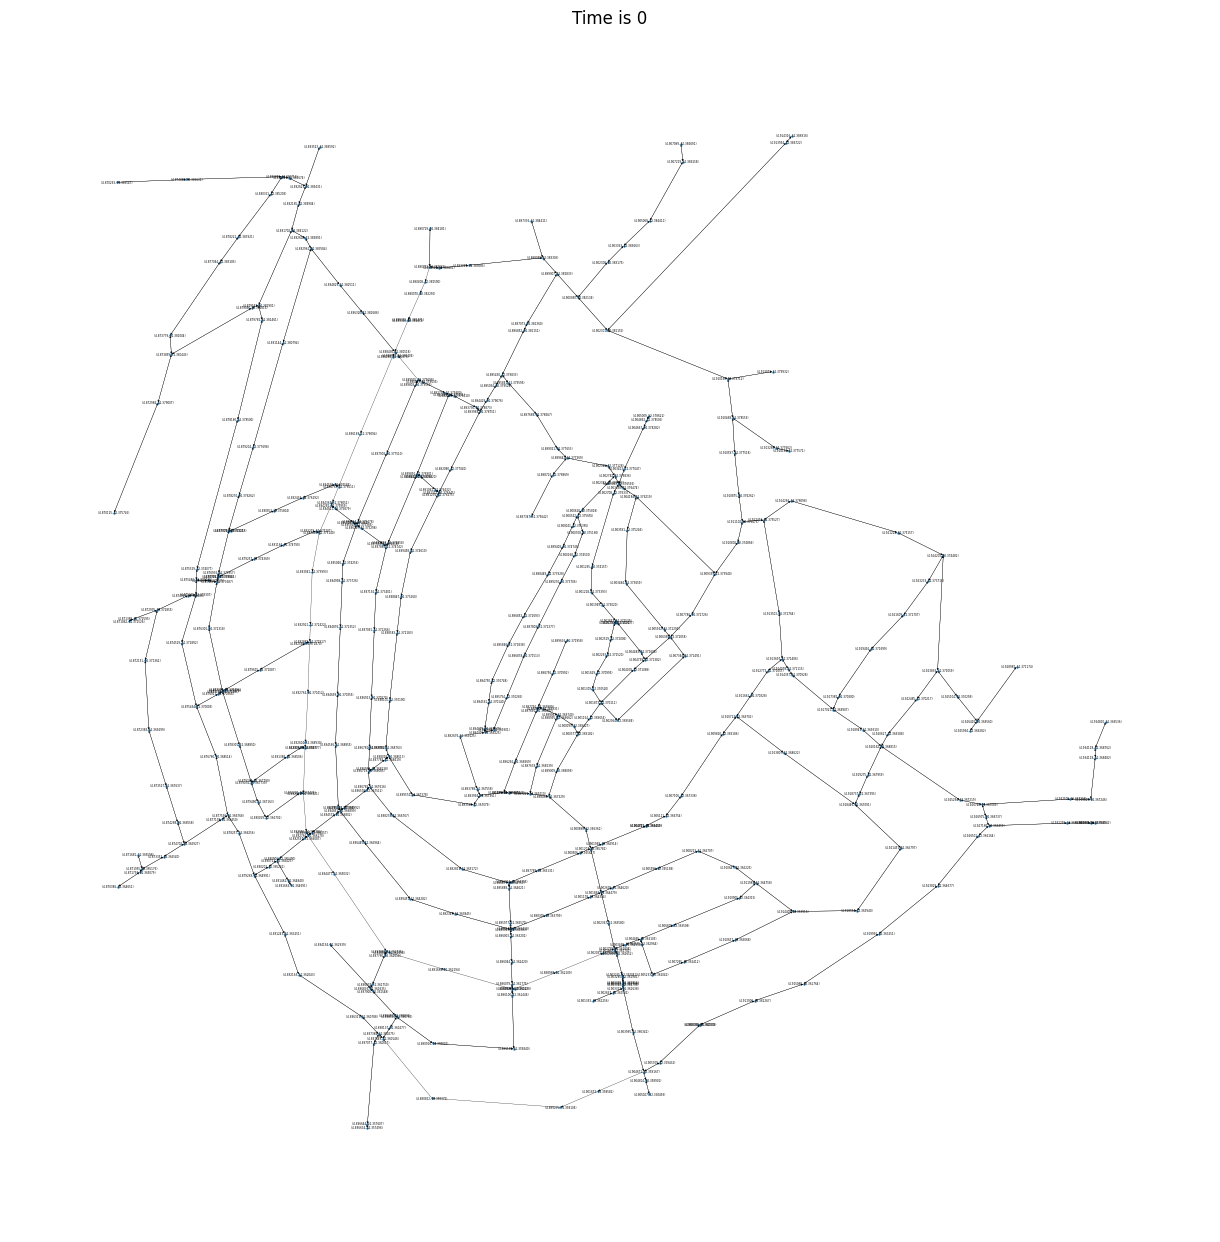

In [86]:
# Animation
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'orange', 'lime']
vessel_marker_styles = {'FPPV': 'o','SPPV': '^', 'RPPV': 's', 'FCV1': '+', 'FCV2': '+', 'FCV3': '+', 'FCV4': '+', }

fig = plt.figure(figsize=[12, 12])

node_attributes = nx.get_node_attributes(FG, 'geometry')
pos = {node: (geom.x, geom.y) for node, geom in node_attributes.items()}

nx.draw(FG, pos,
        with_labels=True,
        node_size=0.5,
        font_size=2,
        width=0.2,
        arrowsize=3)

# Create locations and paths for all vessels
locations = [plt.plot([], [], marker=vessel_marker_styles[vessel.name[-4:]], 
                      color=colors[i % len(colors)], markersize=15)[0] for i, vessel in enumerate(vessels)]
paths = [plt.plot([], [], '-', color=colors[i % len(colors)])[0] for i in range(len(vessels))]
time_text = plt.title("")

def init():
    for location, path in zip(locations, paths):
        location.set_data([], [])
        path.set_data([], [])
    time_text.set_text("Time is 0")

def animate(i):
    for j, (location, path) in enumerate(zip(locations, paths)):
        if j >= len(all_timestamps_x):
            continue
        if i >= len(all_timestamps_x[j]):
            continue        
        this_x = all_timestamps_x[j][i]
        this_y = all_timestamps_y[j][i]

        location.set_data(this_x, this_y)
        time_text.set_text("Time is {}".format(int(all_timestamps_t[j][i])))

        if i > 0:
            past_x = all_timestamps_x[j][:i]
            past_y = all_timestamps_y[j][:i]

            path.set_data(past_x, past_y)

    return locations + paths + [time_text]

ani = animation.FuncAnimation(fig, animate, np.arange(0, len(all_timestamps_t[0])), init_func=init)
ani.save('V01.gif', writer='pillow', fps=5)